# EX2: CBC-GW Injection
In this example we load an LVK posterior from zenodo and compute the FI evidence for the CBC model.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import bilby
import numpy as np
import os, shutil
from collections import namedtuple
import logging
import matplotlib.pyplot as plt
from funnel.plotting import plot_fi_evidence_results
from funnel.fi_core import get_fi_lnz_list

np.random.seed(42)

CLEAN = False
OUTDIR = 'out_gwinj'

if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

## Simple 2-parameter inferece
### Nested sampling LnZ Calculation

In [33]:
bilby_logger = logging.getLogger("bilby")
bilby_logger.setLevel(logging.CRITICAL)

# Simulate signal
duration, sampling_freq, min_freq = 4, 1024., 20
injection_parameters = dict(
    mass_1=36.0, mass_2=29.0,  # 2 mass parameters
    a_1=0.1, a_2=0.1, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0,  # 6 spin parameters
    ra=1.375, dec=-1.2108, luminosity_distance=2000.0, theta_jn=0.0,  # 7 extrinsic parameters
    psi=2.659, phase=1.3,
    geocent_time=1126259642.413,
)
inj_m1, inj_m2 = injection_parameters['mass_1'], injection_parameters['mass_2']
inj_chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(inj_m1, inj_m2)
inj_q = bilby.gw.conversion.component_masses_to_mass_ratio(inj_m1, inj_m2)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_freq,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(
        waveform_approximant="IMRPhenomD",
        reference_frequency=20.0,
        minimum_frequency=min_freq,
    )
)

# Inject the signal into 1 detectors LIGO-Hanford (H1) at design sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_freq,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)
# We sample in chirp-mass and mass-ratio, however--these are quite un-astrophysical priors
# but in post-processing convert to uniform-in-component masses
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
    "theta_jn",
    "luminosity_distance",
]:
    priors[key] = injection_parameters[key]
priors["chirp_mass"] = bilby.gw.prior.UniformInComponentsChirpMass(
    minimum=inj_chirp_mass - 5,
    maximum=inj_chirp_mass + 5
)

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(duration, min_freq);

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
)

label = "injection"
res_fname = f"{OUTDIR}/{label}_result.json"
if os.path.exists(res_fname):
    result = bilby.gw.result.CBCResult.from_json(filename=res_fname)
else:
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        npoints=1000,
        dlogz=0.1,
        injection_parameters=injection_parameters,
        outdir=OUTDIR,
        label=label,
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        result_class=bilby.gw.result.CBCResult,
    )

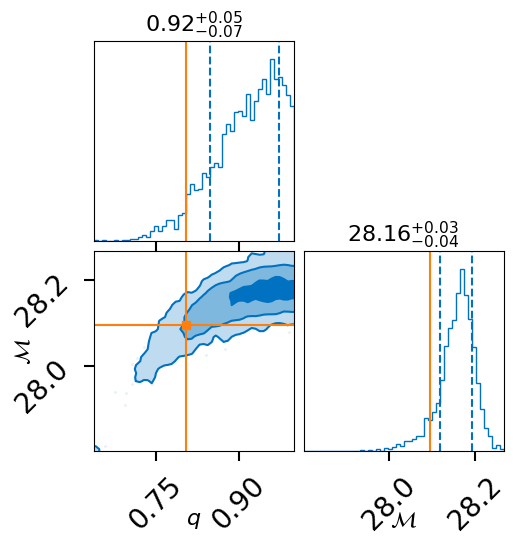

In [5]:
fig = result.plot_corner()
post = result.posterior[['mass_ratio', 'chirp_mass', 'log_prior', 'log_likelihood']]
lnz = result.log_evidence
lnz_err = result.log_evidence_err
fig

In [12]:
print(f"lnZ = {lnz:.2f} +/- {lnz_err:.2f}")
print(f"lnBF = {result.log_bayes_factor:.2f}")

lnZ = -1984.29 +/- 0.10
lnBF = 70.70


In [19]:
likelihood.parameters.update(injection_parameters)
print(f"LnL: {likelihood.log_likelihood():.2f}")
print(f"Noise LnL: {likelihood.noise_log_likelihood():.2f}")
print(f"LnL-Noise LnL: {likelihood.log_likelihood_ratio():.2f}")

LnL: -1964.89
Noise LnL: -2054.98
LnL- Noise LnL: 90.09


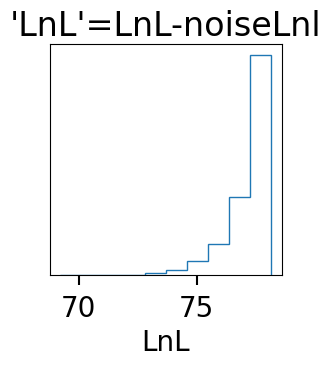

In [28]:
plt.figure(figsize=(3,3))
plt.hist(result.posterior.log_likelihood, histtype='step')
plt.xlabel("LnL")
plt.yticks([])
plt.title("'LnL'=LnL-noiseLnl");

NOTE: the LVK stores the log-likelihood - noise log-likelihood in the column labeled 'log-likelihood'

### Compute FI evidence

In [7]:
lnz_file = f"{OUTDIR}/lnz.npz"
lnzs, r_vals, _ = get_fi_lnz_list(post, num_ref_params=100, cache_fn=lnz_file)

|funnel|INFO| Calculating FI LnZ using a posterior sample of size: (2653, 4) 


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s]

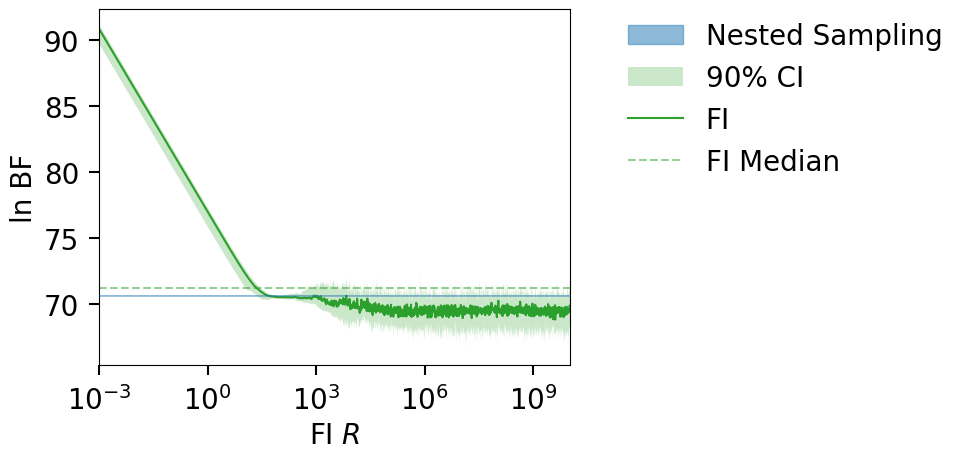

In [42]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals, sampling_lnz=[result.log_bayes_factor])
fig = plot_fi_evidence_results(**plt_kwgs)
fig.tight_layout()
fig.gca().set_ylabel(r"ln BF");

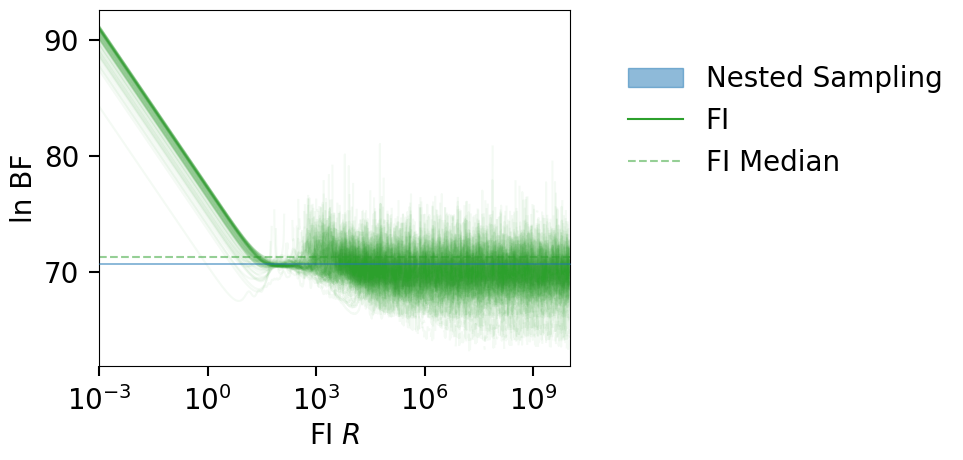

In [43]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True)
fig.tight_layout()
fig.gca().set_ylabel(r"ln BF");

## 15-D parameter inference

We download a pre-run LVK injection.

In [7]:
import bilby

# load the LVK posterior
FPATH = '128_cpus_v1_0_result.hdf5'

LVK_data = namedtuple("LVK_data", "posterior, lnz, lnz_err, lnBF")

def load_lvk_data(fpath):
    r = bilby.gw.result.CBCResult.from_hdf5(fpath)
    post = r.posterior
    sampling_params =r.search_parameter_keys + ['log_likelihood', 'log_prior', 'luminosity_distance']
    lnz, lnz_err =  r.log_evidence, r.log_evidence_err
    lnBF = r.log_bayes_factor
    post = post[sampling_params]
    post = post.loc[:, post.nunique() > 1]
    return LVK_data(post, lnz, lnz_err, lnBF)


CBC_data = load_lvk_data(FPATH)

In [8]:
print(f"Posterior shape: {CBC_data.posterior.shape}")
print(f"LnZ: {CBC_data.lnz:.2f} +/- {CBC_data.lnz_err:.2f}")
print(f"LnBF: {CBC_data.lnBF}")
CBC_data.posterior.head().T

Posterior shape: (15196, 17)
LnZ: -16332.68 +/- 0.11
LnBF: 56.96249503300896


,0,1,2,3,4
chirp_mass,17.303518,17.137896,17.406246,17.221114,17.224999
mass_ratio,0.640732,0.363822,0.475442,0.716670,0.535031
a_1,0.122786,0.126647,0.208230,0.124358,0.064088
a_2,0.294212,0.671431,0.858286,0.436716,0.239654
tilt_1,2.671935,1.089454,0.899129,2.487101,1.332991
tilt_2,0.617993,1.095211,1.673787,1.440678,1.530625
phi_12,5.277061,5.083531,0.924704,4.632946,5.622373
phi_jl,5.421349,0.331844,3.584094,4.388201,4.657011
cos_theta_jn,0.649265,-0.750138,-0.906039,-0.887552,-0.956641
psi,3.033949,1.530611,2.617934,1.037721,3.061500


NOTE: the `log-likelihood` column is actually the `lnl-noise Lnl` (the `log-likelihood-ratio`).

### Compute FI LnZ

#### Using a downsampled posterior sample for speed

In [9]:
OUTDIR = 'out_inj_downsampled'
CLEAN = True
if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

# USING DOWNSAMPLED POSTERIOR SAMPLES
N_SAMP = 10000
N_REF_POINTS = 100
post = CBC_data.posterior.sample(N_SAMP, weights=np.exp(CBC_data.posterior.log_likelihood))
print(f"Using {100*(len(post)/len(CBC_data.posterior)):.2f}% of posterior samples, and trying out {N_REF_POINTS} reference points.")
lnzs, r_vals, _ = get_fi_lnz_list(
    post,
    num_ref_params=N_REF_POINTS,
    r_vals=np.geomspace(10, 1e9, 100),
    cache_fn=f'{OUTDIR}/lnzs.npz',
    weight_samples_by_lnl=True,
)

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (10000, 15) 


Using 65.81% of posterior samples, and trying out 100 reference points.


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

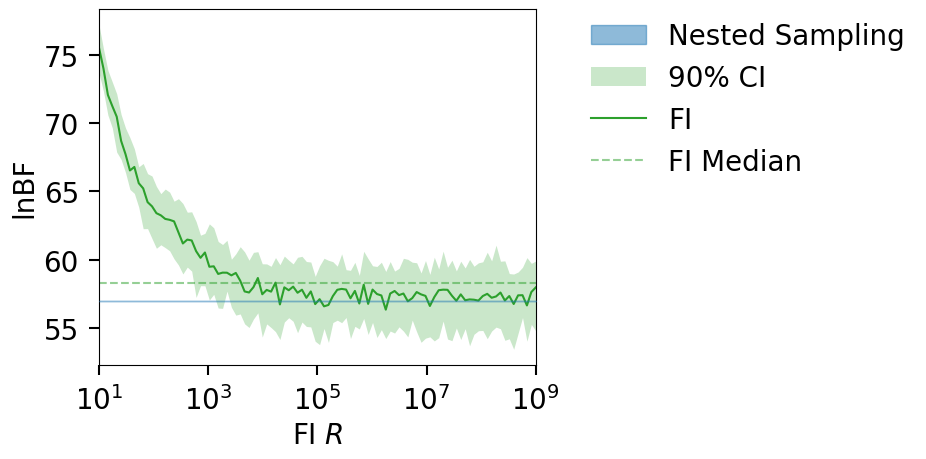

In [10]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals,sampling_lnz=[CBC_data.lnBF])
fig = plot_fi_evidence_results(**plt_kwgs)
fig.gca().set_ylabel("lnBF");

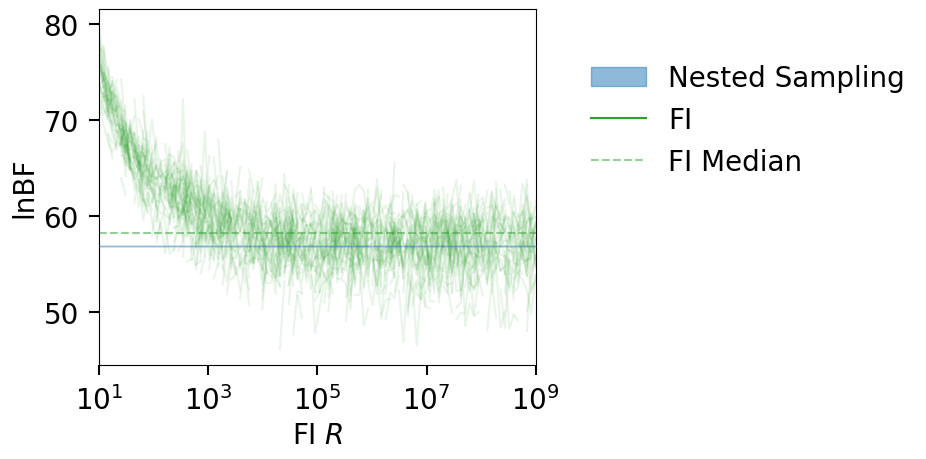

In [11]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True, plt_kwgs=dict(alpha=.1))
fig.gca().set_ylabel("lnBF");

#### Using the full posterior sample but a few refernce points

In [12]:
OUTDIR = 'out_inj2'
CLEAN = True
if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

N_REF_POINTS = 100
post = CBC_data.posterior
lnzs, r_vals, _ = get_fi_lnz_list(
    post,
    num_ref_params=N_REF_POINTS,
    r_vals=np.linspace(1e5, 2e5, 100),
    cache_fn=f'{OUTDIR}/lnzs.npz',
)

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (15196, 15) 


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

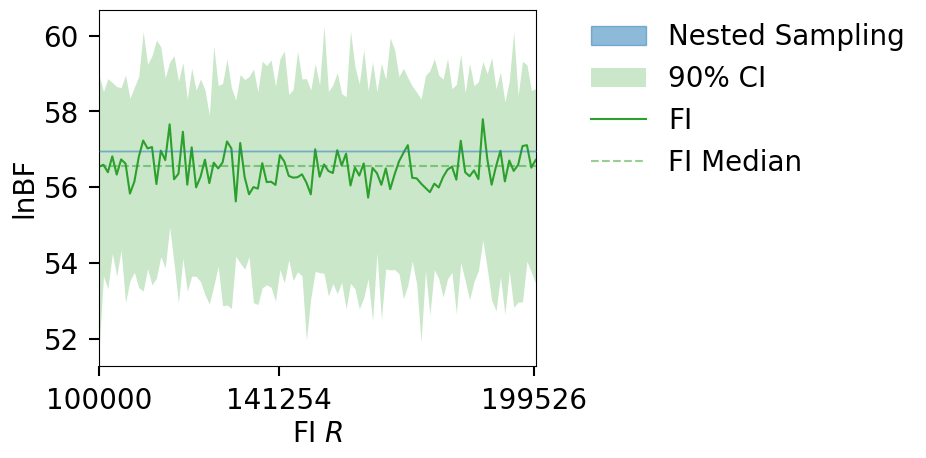

In [16]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals,sampling_lnz=[CBC_data.lnBF])
fig = plot_fi_evidence_results(**plt_kwgs)
ax = fig.gca()
ax.set_ylabel("lnBF");
ax.set_xscale('linear')
# use 10^x labels
ax.set_xticks(np.logspace(5, 5.3, 3))

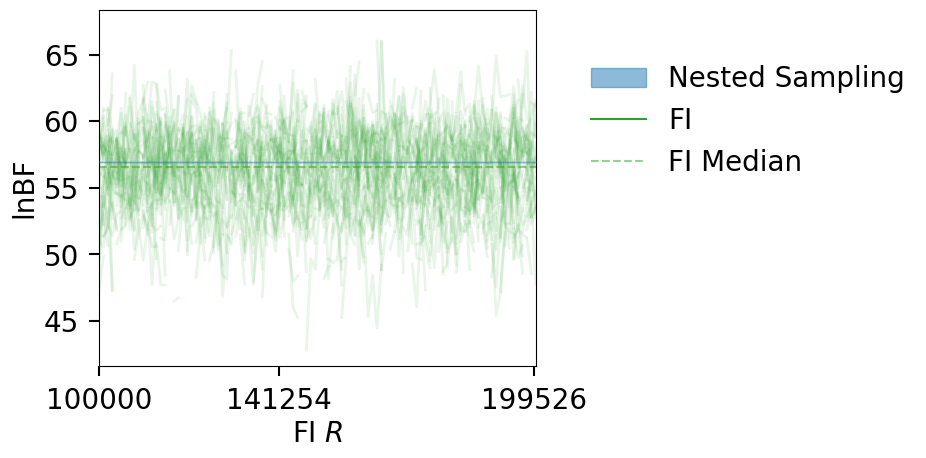

In [18]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True, plt_kwgs=dict(alpha=0.1, lw=2))
ax = fig.gca()
ax.set_ylabel("lnBF");
ax.set_xscale('linear')
# use 10^x labels
ax.set_xticks(np.logspace(5, 5.3, 3))

In [20]:
# numpy count of nans in lnzs
print(f"Percent of nans: {100* (np.sum(np.isnan(lnzs))/ len(lnzs.ravel()))} %")


Percent of nans: 50.21 %
